# **SentimentArcs (Part 5): Transformer Models**

```
Jon Chun
12 Jun 2021: Started
12 Apr 2022: Last Update
```

TODO: 
* check for recovery from multiple runs/overwrites
* pull save repetitive 3code blocks checkpoint code into single def
* Force_Recompute = True

In [ ]:
# Make sure using a GPU

# Tesla V100 = (3.0 x) P100 (2 vCPUs)
#       P100 = (1.6 x) K80  (2 vCPUs/12GB RAM)
#       P100 ~ T4 
#       K80  = (     ) NVIDA GeForce RTX 3080 Ti
#
# High RAM Colab Pro  32GB RAM     $9.99/mo
#          Colab Pro+ 52GB        $49.95/mo

# Paperspace Free & Paid JupyterLab vs Google Colab
# https://blog.paperspace.com/alternative-to-google-colab-pro/#:~:text=Most%20notable%20is%20that%20the,and%2012%20GB%20of%20RAM.&text=Meanwhile%2C%20in%20Paperspace%20Gradient%2C%20GPU,a%20Free%20or%20Paid%20instance. 
# https://www.kaggle.com/general/198232
# https://towardsdatascience.com/deep-learning-on-a-budget-450-egpu-vs-google-colab-494f9a2ff0db (3080 vs Colab)
# https://towardsdatascience.com/when-to-use-cpus-vs-gpus-vs-tpus-in-a-kaggle-competition-9af708a8c3eb (Kaggle Comp)
# https://towardsdatascience.com/google-colab-pro-is-it-worth-49-99-c542770b8e56 (Colab Pro+)
# https://www.quora.com/Which-is-better-Google-Colab-or-Kaggle-Notebook (Kaggle vs Colab GPUs)

!nvidia-smi

# **[RESTART RUNTIME] May be Required for these Libaries**

# **[STEP 1] Manual Configuration/Setup**



In [ ]:
!pip install transformers[sentencepiece]

     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 66.2 MB/s 
     |████████████████████████████████| 77 kB 8.6 MB/s 
     |████████████████████████████████| 6.6 MB 48.9 MB/s 
     |████████████████████████████████| 895 kB 63.2 MB/s 
     |████████████████████████████████| 1.2 MB 27.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## (Popups) Connect Google gDrive

In [ ]:
# [INPUT REQUIRED]: Authorize access to Google gDrive

# Connect this Notebook to your permanent Google Drive
#   so all generated output is saved to permanent storage there

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("Attempting to attach your Google gDrive to this Colab Jupyter Notebook")
  drive.mount('/gdrive')
else:
  print("Your Google gDrive is attached to this Colab Jupyter Notebook")

## (3 Inputs) Define Directory Tree

In [ ]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.

# #@markdown **Instructions**

# #@markdown Set Directory and Corpus names:
# #@markdown <li> Set <b>Path_to_SentimentArcs</b> to the project root in your **GDrive folder**
# #@markdown <li> Set <b>Corpus_Genre</b> = [novels, finance, social_media]
# #@markdown <li> <b>Corpus_Type</b> = [reference_corpus, new_corpus]
# #@markdown <li> <b>Corpus_Number</b> = [1-20] (id nunmber if a new_corpus)

#@markdown <hr>

# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/sentimentarcs_notebooks/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}


#@markdown Set this to the project root in your <b>GDrive folder</b>
#@markdown <br> (e.g. /<wbr><b>gdrive/MyDrive/research/sentiment_arcs/</b>)

#@markdown <hr>

#@markdown **Which type of texts are you cleaning?** \

Corpus_Genre = "novels" #@param ["novels", "social_media", "finance"]

# Corpus_Type = "reference" #@param ["new", "reference"]
Corpus_Type = "new" #@param ["new", "reference"]


Corpus_Number = 3 #@param {type:"slider", min:1, max:10, step:1}


#@markdown Put in the corresponding Subdirectory under **./text_raw**:
#@markdown <li> All Texts as clean <b>plaintext *.txt</b> files 
#@markdown <li> A <b>YAML Configuration File</b> describing each Texts

#@markdown Please verify the required textfiles and YAML file exist in the correct subdirectories before continuing.

print('Current Working Directory:')
%cd $Path_to_SentimentArcs

print('\n')

if Corpus_Type == 'reference':
  SUBDIR_SENTIMENT_RAW = f'sentiment_raw_{Corpus_Genre}_reference'
  SUBDIR_TEXT_CLEAN = f'text_clean_{Corpus_Genre}_reference'
else:
  SUBDIR_SENTIMENT_RAW = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}/'
  SUBDIR_TEXT_CLEAN = f'text_clean_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}/'

# PATH_SENTIMENT_RAW = f'./sentiment_raw/{SUBDIR_TEXT_RAW}'
# PATH_TEXT_CLEAN = f'./text_clean/{SUBDIR_TEXT_CLEAN}'
PATH_SENTIMENT_RAW = f'./sentiment_raw/{SUBDIR_SENTIMENT_RAW}'
PATH_TEXT_CLEAN = f'./text_clean/{SUBDIR_TEXT_CLEAN}'

# TODO: Clean up
# SUBDIR_TEXT_CLEAN = PATH_TEXT_CLEAN

print(f'PATH_SENTIMENT_RAW:\n  [{PATH_SENTIMENT_RAW}]')
print(f'SUBDIR_SENTIMENT_RAW:\n  [{SUBDIR_SENTIMENT_RAW}]')

print('\n')

print(f'PATH_TEXT_CLEAN:\n  [{PATH_TEXT_CLEAN}]')
print(f'SUBDIR_TEXT_CLEAN:\n  [{SUBDIR_TEXT_CLEAN}]')

# **[STEP 2] Automatic Configuration/Setup**

## (each time) Custom Libraries & Define Globals

In [ ]:
# Add PATH for ./utils subdirectory

import sys
import os

!python --version

print('\n')

PATH_UTILS = f'{Path_to_SentimentArcs}utils'
PATH_UTILS

sys.path.append(PATH_UTILS)

print('Contents of Subdirectory [./sentiment_arcs/utils/]\n')
!ls $PATH_UTILS

# More Specific than PATH for searching libraries
# !echo $PYTHONPATH

In [ ]:
# Review Global Variables and set the first few

import global_vars as global_vars

global_vars.SUBDIR_SENTIMENTARCS = Path_to_SentimentArcs
global_vars.Corpus_Genre = Corpus_Genre
global_vars.Corpus_Type = Corpus_Type
global_vars.Corpus_Number = Corpus_Number

global_vars.SUBDIR_SENTIMENT_RAW = SUBDIR_SENTIMENT_RAW
global_vars.PATH_SENTIMENT_RAW = PATH_SENTIMENT_RAW

global_vars.SUBDIR_TEXT_CLEAN = SUBDIR_TEXT_CLEAN
global_vars.PATH_TEXT_CLEAN = PATH_TEXT_CLEAN

from utils import sa_config # (e.g. define TEST_WORDS_LS)

sa_config.set_globals()

global_vars.TEST_WORDS_LS
print('\n')

dir(global_vars)

In [ ]:
# Initialize and clean for each iteration of notebook

# dir(global_vars)

global_vars.corpus_texts_dt = {}
global_vars.corpus_titles_dt = {}

In [ ]:
# Import SentimentArcs Utilities to define Directory Structure
#   based the Selected Corpus Genre, Type and Number

!pwd 
print('\n')

# from utils import sa_config # .sentiment_arcs_utils
from utils import sa_config

print('Objects in sa_config()')
print(dir(sa_config))
print('\n')

# Directory Structure for the Selected Corpus Genre, Type and Number
sa_config.get_subdirs(Path_to_SentimentArcs, Corpus_Genre, Corpus_Type, Corpus_Number, 'none')


In [ ]:
%whos 

## (each time) Read YAML Configuration for Corpus and Models 

In [ ]:
# from utils import sa_config # .sentiment_arcs_utils

import yaml

from utils import read_yaml

print('Objects in read_yaml()')
print(dir(read_yaml))
print('\n')

# Directory Structure for the Selected Corpus Genre, Type and Number
read_yaml.read_corpus_yaml(Corpus_Genre, Corpus_Type, Corpus_Number)

print('SentimentArcs Model Ensemble ------------------------------\n')
model_titles_ls = global_vars.models_titles_dt.keys()
print('\n'.join(model_titles_ls))


print('\n\nCorpus Texts ------------------------------\n')
corpus_titles_ls = list(global_vars.corpus_titles_dt.keys())
print('\n'.join(corpus_titles_ls))


print(f'\n\nThere are {len(model_titles_ls)} Models in the SentimentArcs Ensemble above.\n')
print(f'\nThere are {len(corpus_titles_ls)} Texts in the Corpus above.\n')
print('\n')

global_vars.corpus_titles_dt

In [ ]:
global_vars.models_titles_dt.items()

In [ ]:
global_vars.corpus_titles_dt

## Configure Jupyter Notebook

In [ ]:
# Configure Jupyter

# To reload modules under development

# Option (a)
%load_ext autoreload
%autoreload 2
# Option (b)
# import importlib
# importlib.reload(functions.readfunctions)


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from IPython.display import Image
from ipywidgets import widgets, interactive

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Install Python Libraries

In [ ]:
# Intentionally left blank

## Load Libraries

In [ ]:
import numpy as np

from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('max_colwidth', 100) # -1)

from glob import glob
import copy
import json

In [ ]:
# Scikit Utilities, Metrics, Pipelines and Models

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


In [ ]:
"""

# Define Globals

# Main data structure: Dictionary (key=text_name) of DataFrames (cols: text_raw, text_clean)
corpus_texts_dt = {}

# Verify in SentimentArcs Root Directory
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')

%run -i './utils/get_globals.py'

SLANG_DT.keys()
""";

## Setup Matplotlib Style

* https://matplotlib.org/stable/tutorials/introductory/customizing.html

In [ ]:
# Configure Matplotlib

# View available styles
# plt.style.available

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/config_matplotlib.py'

config_matplotlib()

print('Matplotlib Configuration ------------------------------')
print('\n  (Uncomment to view)')
# plt.rcParams.keys()
print('\n  Edit ./utils/config_matplotlib.py to change')

## Setup Seaborn Style

In [ ]:
# Configure Seaborn

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/config_seaborn.py'

config_seaborn()

print('Seaborn Configuration ------------------------------\n')
# print('\n  Update ./utils/config_seaborn.py to display seaborn settings')


## Python Utility Functions

### (each time) Generate Convenient Data Lists

In [ ]:
# Derive List of Texts in Corpus a)keys and b)full author and titles

print('Dictionary: corpus_titles_dt')
global_vars.corpus_titles_dt
print('\n')

corpus_texts_ls = list(global_vars.corpus_titles_dt.keys())
print(f'\nCorpus Texts:')
for akey in corpus_texts_ls:
  print(f'  {akey}')
print('\n')

print(f'\nNatural Corpus Titles:')
corpus_titles_ls = [x[0] for x in list(global_vars.corpus_titles_dt.values())]
for akey in corpus_titles_ls:
  print(f'  {akey}')


In [ ]:
# Get Model Families of Ensemble

from utils.get_model_families import get_ensemble_model_famalies

global_vars.model_ensemble_dt = get_ensemble_model_famalies(global_vars.models_titles_dt)

print('\nTest: Lexicon Family of Models:')
global_vars.model_ensemble_dt['lexicon']

### File Functions

In [ ]:
# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

%run -i './utils/file_utils.py'
# from utils.file_utils import *

# %run -i './utils/file_utils.py'

# TODO: Not used? Delete?
# get_fullpath(text_title_str, ftype='data_clean', fig_no='', first_note = '',last_note='', plot_ext='png', no_date=False)

# **[STEP 3] Read all Preprocessed Novels**

## Read Cleaned Text

In [ ]:
# Verify cwd and subdir of Cleaned Corpus Texts

print('Current Working Directory:')
!pwd

print(f'\nSubdir with all Cleaned Texts of Corpus:\n  {SUBDIR_TEXT_CLEAN}')

print(f'\n\nFilenames of Cleaned Texts:\n')
!ls -1 {Path_to_SentimentArcs}{PATH_TEXT_CLEAN}

print('\n')

print(corpus_texts_ls)

In [ ]:
"""

# Create a List (preprocessed_ls) of all preprocessed text files

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)

try:
    preprocessed_ls = glob(f'{PATH_TEXT_CLEAN}/*.csv')
    preprocessed_ls = [x.split('/')[-1] for x in preprocessed_ls]
    preprocessed_ls = [x.split('.')[0] for x in preprocessed_ls]
except IndexError:
    raise RuntimeError('No csv file found')

print('\n'.join(preprocessed_ls))
print('\n')
print(f'Found {len(preprocessed_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')

"""

In [ ]:
# Read all preprocessed text files into master DataFrame (corpus_dt)

global_vars.corpus_texts_dt = {}

for i,atext in enumerate(corpus_texts_ls):
  print(f'Processing #{i}: {atext}...')
  afile_fullpath = f'{PATH_TEXT_CLEAN}/{atext}.csv'
  print(f'               {afile_fullpath}')
  atext_df = pd.read_csv(afile_fullpath, index_col=[0])
  global_vars.corpus_texts_dt[atext] = atext_df

In [ ]:
# Verify the Text read into master Dictionary of DataFrames

global_vars.corpus_texts_dt.keys()
print('\n')
print(f'There were {len(global_vars.corpus_texts_dt)} preprocessed Text read into the Dict global_vars.corpus_texts_dt')

In [ ]:
# Check if there are any Null strings in the text_clean columns

for i, atext in enumerate(list(global_vars.corpus_texts_dt.keys())):
  print(f'\nNovel #{i}: {atext}')
  nan_ct = global_vars.corpus_texts_dt[atext].text_clean.isna().sum()
  if nan_ct > 0:
    print(f'      {nan_ct} Null strings in the text_clean column')

In [ ]:
# Fill in all the Null value of text_clean with placeholder 'empty_string'

for i, atext in enumerate(list(global_vars.corpus_texts_dt.keys())):
  # print(f'Novel #{i}: {atext}')
  # Fill all text_clean == Null with 'empty_string' so sentimentr::sentiment doesn't break
  global_vars.corpus_texts_dt[atext].iloc[global_vars.corpus_texts_dt[atext].text_clean.isna()] = 'empty_string'

In [ ]:
# Verify DataFrame of first Text in Corpus Dictionary

global_vars.corpus_texts_dt[next(iter(global_vars.corpus_texts_dt))].head()

In [ ]:
# [SKIP]

In [ ]:
"""

print(f'Trying to find EXISTING Raw Sentiment Datafile:\n  [{FNAME_SENTIMENT_RAW}]\n  in Raw Sentiment Subdir: {SUBDIR_SENTIMENT_RAW}\n')

corpus_texts_dt = {}
subdir_sentiment_raw_ls = os.listdir(SUBDIR_SENTIMENT_RAW)

# Verify in SentimentArcs Root Directory and cd into ./utils for R programs
os.chdir('/gdrive/MyDrive/cdh/sentiment_arcs/')
!pwd

if FNAME_SENTIMENT_RAW not in subdir_sentiment_raw_ls:
  # No Existing Raw Sentiment Data, Just read in Clean Text
  print(f'No EXISTING Raw Sentiment Datafile exists, Start from Stratch...\n')

  # Create a List (texts_clean_ls) of all preprocessed text files
  try:
    texts_clean_ls = glob(f'{SUBDIR_TEXT_CLEAN}*.csv')
    texts_clean_ls = [x.split('/')[-1] for x in texts_clean_ls]
    texts_clean_ls = [x.split('.')[0] for x in texts_clean_ls]
  except IndexError:
    raise RuntimeError('No csv file found')

  # Read all preprocessed text files into master DataFrame (corpus_dt)
  for i,anovel in enumerate(texts_clean_ls):
    print(f'Processing #{i}: {anovel}...')
    afile_fullpath = f'{SUBDIR_TEXT_CLEAN}{anovel}.csv'
    print(f'               {afile_fullpath}')
    anovel_df = pd.read_csv(afile_fullpath, index_col=[0])
    corpus_texts_dt[anovel] = anovel_df

  print('\n'.join(texts_clean_ls))
  print('\n')
  print(f'Found {len(texts_clean_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')
else:
  # Found Existing Raw Sentiment Data with Clean Text, Read Both
  print(f'Found EXISTING  Raw Sentiment Datafile exists, Loading...\n')
  corpus_texts_dt = read_dict_dfs(in_file=FNAME_SENTIMENT_RAW, in_dir=SUBDIR_SENTIMENT_RAW)
  print(f'The  Models have Analyzed these Texts in the Corpus:\n\n  {corpus_texts_dt.keys()}\n\n')    

# Verify Corpus DataFrame
corpus_titles_ls = list(corpus_texts_dt.keys())
# corpus_texts_dt[corpus_titles_ls[0]].head()
corpus_texts_dt[corpus_titles_ls[0]].info()

""";

In [ ]:
models_ls = list(set(global_vars.corpus_texts_dt[corpus_texts_ls[0]].columns) - set(['text_clean','text_raw']))
print(f'There are [{len(models_ls)} Models] Pre-Existing in the Datafile for this Notebook:\n')
models_ls
print('\n')

print(f'There are [{len(corpus_texts_ls)} Texts] in the current Corpus:\n')
corpus_titles_ls

## (del?) If Sentiment Time Series exist, Verify with Plots

In [ ]:
# from sklearn.preprocessing import StandardScaler, RobustScaler

# r_scaler = RobustScaler() 
# z_scaler = StandardScaler()


# **[STEP 4] Transformer Models**

## Common Transformer Setup

In [ ]:
from transformers import pipeline

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

from transformers import AutoTokenizer, AutoModelWithLMHead  # T5Base 50k

In [ ]:
# Define all Corpus Texts & Ensemble Models as global CONSTANTS

model_family = 'transformer'

# Verify in SentimentArcs Root Directory
os.chdir(Path_to_SentimentArcs)
%run -i './utils/get_sentiments.py'

#@markdown If Model Values already exist, Recompute anyway and Overwrite?

Force_Recompute = False #@param {type:"boolean"}

# Get list Names for This Section of Python Lexicon Models

# models_lexicon_ls = ensemble_models_dt['lexicon']
models_pylex_ls = [x for x in global_vars.model_ensemble_dt[model_family]]
print(f'Lexicon Models in this Section:\n')
print(models_pylex_ls)

In [ ]:
global_vars.corpus_texts_dt.keys()

In [ ]:
"""

# from utils import sa_config (e.g. define TEST_WORDS_LS)

from utils import sa_config

sa_config.set_globals()
""";

global_vars.TEST_WORDS_LS



In [ ]:
global_vars.models_titles_dt

In [ ]:
global_vars.model_ensemble_dt.keys()

## **RoBERTa Large 15 Datasets (5 cats)**

In [ ]:
%%time

# NOTE: 00m11s @12:39 on 20220301 Colab Pro 

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")

print(sa_model("I love this!"))

In [ ]:
# Define Model and Test

model_title = 'RoBERTa Large 15DB'
model_name = 'roberta15lg'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

In [ ]:
%%time

# NOTE:   ~40m00s @12:39 on 20220301 Colab Pro P100 (1 Novels)
#       ~1h31m00s @12:39 on 20220301 Colab Pro P100 (2 Novels: 535k, 536k)
#        3h08m00s @03:12 on 20220412 Colab Pro P100 (3 Novels, 628k, 662k, 897k)
#         ~00m00s @19:31 on 20220411 Colab Pro T4 (2 Novels: 535k, 536k)
#          37m27s @14:40 on 20220419 Colab Pro T4 (1 Novel: 502k)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].apply(lambda x: labelscore2fl(classifier(x), sa_model=classifier))
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(sa_model(x), sa_model=model_name))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

Processing #0: pkdick_doandroidsdreamofelectricsheep


  0%|          | 0/5820 [00:00<?, ?it/s]

  [roberta15lg] Sentiment Recomputed and Value Updated
CPU times: user 27min 53s, sys: 6.49 s, total: 27min 59s
Wall time: 28min 17s


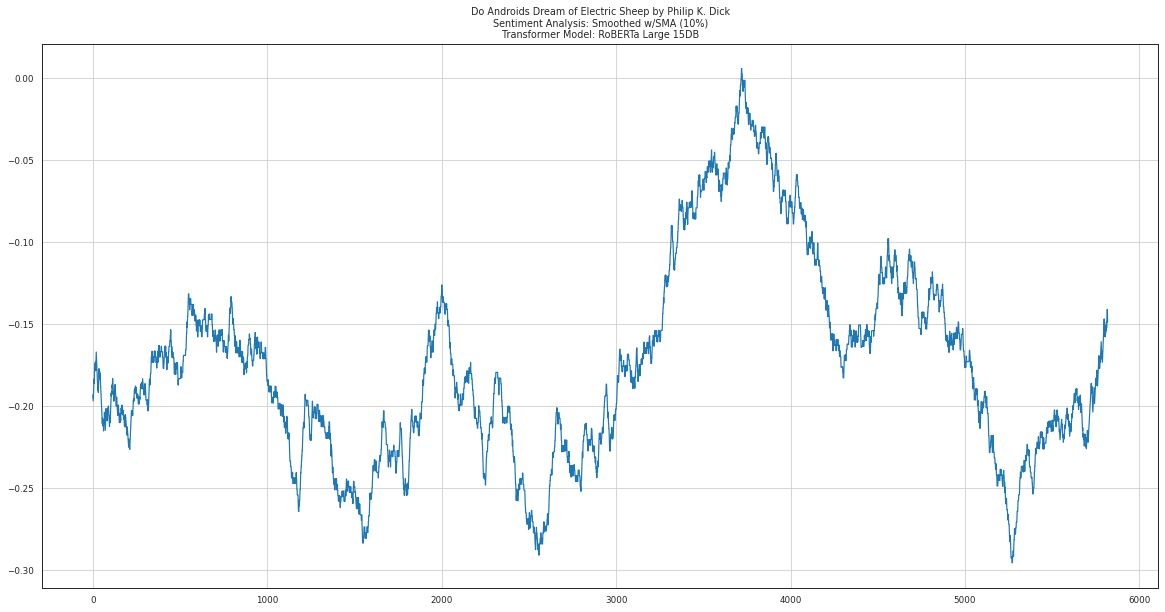

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do android dream of electric sheep,-0.988568
1,A merry little surge of electricity piped by automatic alarm from the mood organ beside his bed ...,a merry little surge of electricity pipe by automatic alarm from the mood organ beside his bed a...,0.998337
2,Surprised - it always surprised him to find himself awake without prior notice - he rose from th...,surprise it always surprise him to find himself awake without prior notice he rise from the bed ...,0.998160
3,"Now, in her bed, his wife Iran opened her gray, unmerry eyes, blinked, then groaned and shut her...",now in her bed his wife iran open her gray unmerry eye blink then groan and shut her eye again,-0.998644
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he say to her,-0.999457


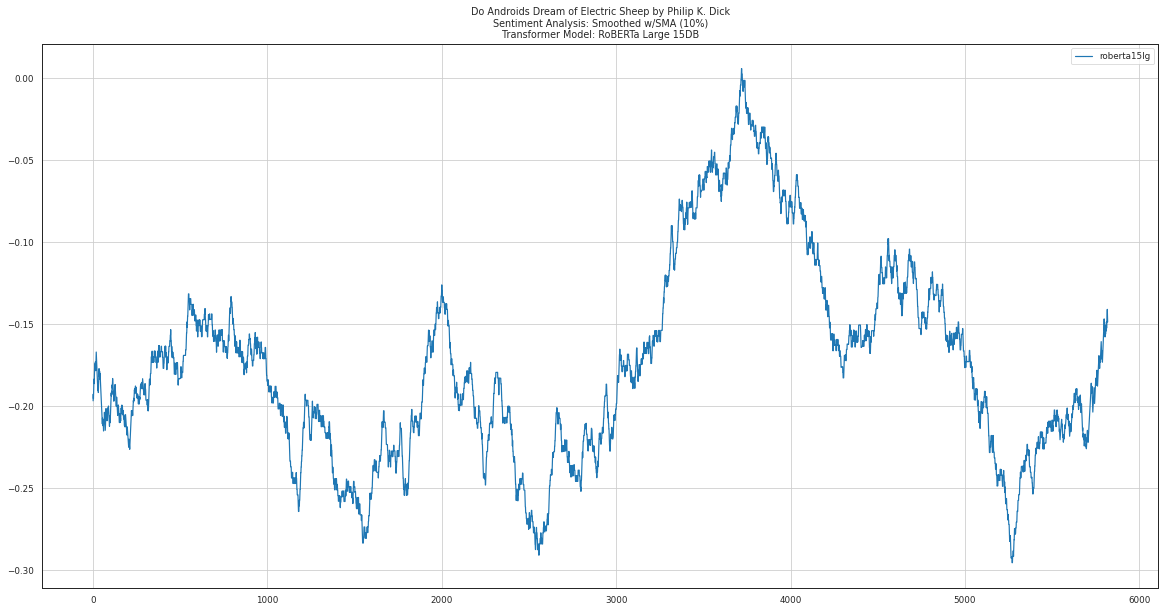

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'roberta15lg'
# model_current = 'roberta15lg'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: novels
     Corpus_Type: new

These Text Titles:



dict_keys(['pkdick_doandroidsdreamofelectricsheep'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_novels_new_corpus5/'

Saving roberta15lg Model for all Texts
Saving file to: ./sentiment_raw/sentiment_raw_novels_new_corpus5//sentiment_raw_novels_new_corpus5_transformer_roberta15lg.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 5590
-rw------- 1 root root 1911427 Apr 20 03:07 sentiment_raw_novels_new_corpus5_all_4syuzhetr.json
-rw------- 1 root root 3418637 Apr 20 03:19 sentiment_raw_novels_new_corpus5_all_8sentimentr.json
-rw------- 1 root root  392712 Apr 20 04:04 sentiment_raw_novels_new_corpus5_transformer_roberta15lg.json


## **Huggingface Distill BERT SST**

In [ ]:
# BUG: Cannot reuse variable name 'sa_model', causes replicated results of first model declared (e.g. roberta15lg)
# sa_model = pipeline("sentiment-analysis")

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis")

In [ ]:
# Define Model and Test

model_title = 'Huggingface DistilBERT'
model_name = 'huggingface'
model_type = 'Transformer'

# Test Emoji
sa_model("We are very happy to show you the 🤗 Transformers library.")
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

In [ ]:
list(global_vars.corpus_texts_dt.keys())

In [ ]:
%%time

# NOTE: 

# NOTE:   10m25s @02:48 on 20220304 Colab Pro T4 (2 Novels: 535k, 536k)
#         24m26s @08:58 on 20220412 Colab Pro P100 (3 Novels: 1.2M, 1.3M, 1.7M)
#         24m17s @11:20 on 20220412 Colab Pro P100 (3 Novels: 1.2M, 1.3M, 1.7M)
#          8m49s @13:52 on 20220412 Colab Pro T4 (2 Texts: 1M, 1.1M)
#          3m05s @22:10 on 20220415 Colab Pro K80 (3 Novels, 628k, 662k, 897k)
#        ~15m05s @13:45 on 20220418 Colab Pro P100 (2 FinTexts, 3.4M 936k)
#          6m26s @15:33 on 20220419 Colab Pro T4 (1 Novel: 502k)

# for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
for indx_obj in enumerate(global_vars.corpus_texts_dt.keys()):
  i, atext = indx_obj
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(sa_model(x), sa_model='huggingface'))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
# print(f'win_per: {win_per}')
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
# print(f'text_title_str: {text_title_str}')
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do android dream of electric sheep,-0.988568,0.888154
1,A merry little surge of electricity piped by automatic alarm from the mood organ beside his bed ...,a merry little surge of electricity pipe by automatic alarm from the mood organ beside his bed a...,0.998337,0.964321
2,Surprised - it always surprised him to find himself awake without prior notice - he rose from th...,surprise it always surprise him to find himself awake without prior notice he rise from the bed ...,0.998160,0.659327
3,"Now, in her bed, his wife Iran opened her gray, unmerry eyes, blinked, then groaned and shut her...",now in her bed his wife iran open her gray unmerry eye blink then groan and shut her eye again,-0.998644,-0.976472
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he say to her,-0.999457,-0.999153


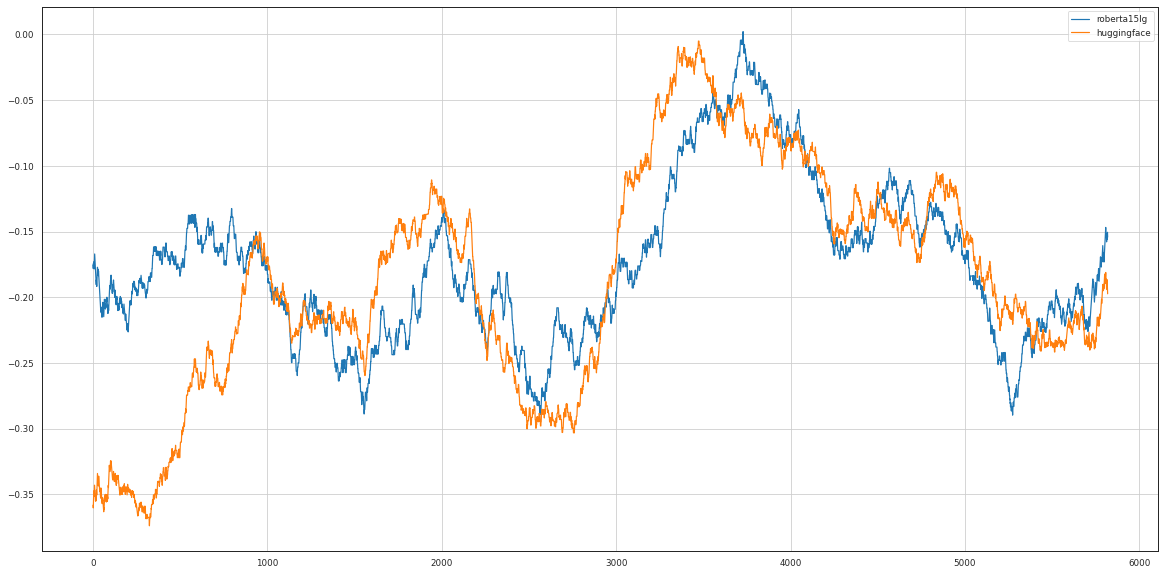

In [ ]:
# Plot all models

models_all_ls = list(global_vars.corpus_texts_dt[corpus_texts_ls[0]].select_dtypes(include=[np.float]).columns)

global_vars.corpus_texts_dt[corpus_texts_ls[0]][models_all_ls].rolling(600, center=True, min_periods=0).mean().plot()
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'huggingface'
# model_current = 'huggingface'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

## **NLPTown Multilingual BERT (5 cats)**

In [ ]:
# NLPTown: Multilingual trained BERT Model

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis",model="nlptown/bert-base-multilingual-uncased-sentiment")

# Test
# print(sa_nlptown("I love this!"))
print(sa_model("I love this!"))

In [ ]:
# Define Model and Test

model_title = 'NLPTown MultiBERT'
model_name = 'nlptown'
model_type = 'Transformer'

# Test Emoji
sa_model("We are very happy to show you the 🤗 Transformers library.")
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  sent_sentiment_fl = sa_model(asent_str)
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl}\n')

In [ ]:
%%time

# NOTE:   9m05s @16:40 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity)
#        ~8m07s @16:49 on 20220201 Colab Pro P100 (1 Novel: scollins_thehungergames1)
#        25m14s @08:58 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)
#        25m14s @11:53 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)
#       ~18m30s @14:23 on 20220412 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#        12m39s @15:40 on 20220419 Colab Pro T4 (1 Novel: 502k)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(sa_model(x), sa_model='nlptown'))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'nlptown'
# model_current = 'nlptown'

os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

## **Yelp Finetuned BERT (5 cats)**

In [ ]:
# Yelp Trained BERT Sentiment Classifier

tokenizer = AutoTokenizer.from_pretrained("gilf/english-yelp-sentiment")

sa_model = None
del sa_model
sa_model = AutoModelForSequenceClassification.from_pretrained("gilf/english-yelp-sentiment")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)
print(f'Yelp SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'\n\nSENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

In [ ]:
# Define Model and Test

model_title = 'Yelp BERT'
model_name = 'yelp'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
aemoji_str_enc = tokenizer(emoji_str, return_tensors='pt')
logits_tensor = sa_model(**aemoji_str_enc)
sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
print(f'Emoji String: {emoji_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  aword_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m19s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)
#          49m55s @12:45 on 20220412 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#          49m55s @14:54 on 20220412 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#          30m27s @23:32 on 20220412 Colab Pro P100 (3 Novels, 1.2M, 1.3M, 1.7M)
#          13m33s @15:54 on 20220419 Colab Pro T4 (1 Novel: 502k)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_model(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


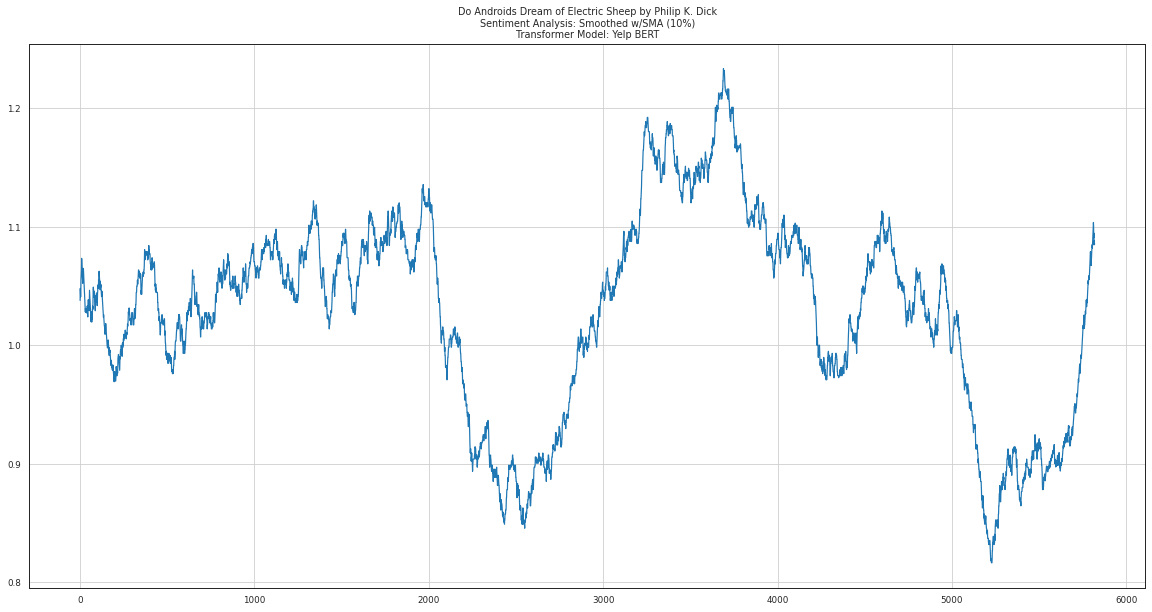

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

,text_raw,text_clean,roberta15lg,huggingface,nlptown,yelp
0,DO ANDROIDS DREAM OF ELECTRIC SHEEP?,do android dream of electric sheep,-0.988568,0.888154,4.320016,4
1,A merry little surge of electricity piped by automatic alarm from the mood organ beside his bed ...,a merry little surge of electricity pipe by automatic alarm from the mood organ beside his bed a...,0.998337,0.964321,4.597209,2
2,Surprised - it always surprised him to find himself awake without prior notice - he rose from th...,surprise it always surprise him to find himself awake without prior notice he rise from the bed ...,0.998160,0.659327,4.639219,0
3,"Now, in her bed, his wife Iran opened her gray, unmerry eyes, blinked, then groaned and shut her...",now in her bed his wife iran open her gray unmerry eye blink then groan and shut her eye again,-0.998644,-0.976472,0.430815,0
4,"""You set your Penfield too weak he said to her.",you set your penfield too weak he say to her,-0.999457,-0.999153,0.457059,0


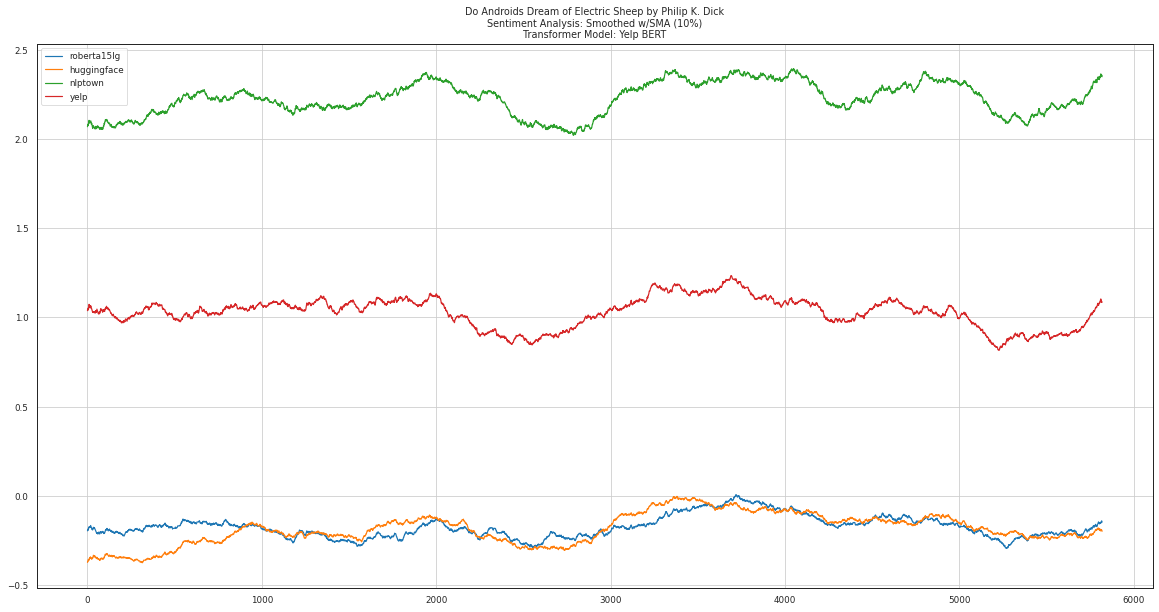

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'yelp'
# model_current = 'yelp'


os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'


# Filter out all models but Current One to Save
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')

Currently in SentimentArcs root directory:
/gdrive/MyDrive/sentimentarcs_notebooks
Saving Text_Type: novels
     Corpus_Type: new

These Text Titles:



dict_keys(['pkdick_doandroidsdreamofelectricsheep'])


To This Subdirectory:



'./sentiment_raw/sentiment_raw_novels_new_corpus5/'

Saving yelp Model for all Texts
Saving file to: ./sentiment_raw/sentiment_raw_novels_new_corpus5//sentiment_raw_novels_new_corpus5_transformer_yelp.json


In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

total 6575
-rw------- 1 root root 1911427 Apr 20 03:07 sentiment_raw_novels_new_corpus5_all_4syuzhetr.json
-rw------- 1 root root 3418637 Apr 20 03:19 sentiment_raw_novels_new_corpus5_all_8sentimentr.json
-rw------- 1 root root  392712 Apr 20 04:04 sentiment_raw_novels_new_corpus5_transformer_roberta15lg.json
-rw------- 1 root root  392748 Apr 20 04:10 sentiment_raw_novels_new_corpus5_transformer_huggingface.json
-rw------- 1 root root  364785 Apr 20 04:18 sentiment_raw_novels_new_corpus5_transformer_nlptown.json
-rw------- 1 root root  250315 Apr 20 04:28 sentiment_raw_novels_new_corpus5_transformer_yelp.json


## **Hinglish Mixed Code BERT (3 cats)**

In [ ]:
# Hindi-English Code Switching BERT Model

tokenizer = AutoTokenizer.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

sa_model = None
del sa_model
sa_model = AutoModelForSequenceClassification.from_pretrained("rohanrajpal/bert-base-multilingual-codemixed-cased-sentiment")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)
print(f'Hinglish SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'\n\nSENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

In [ ]:
# Define Model and Test

model_title = 'Hinglish Dual Code BERT'
model_name = 'hinglish'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
aemoji_str_enc = tokenizer(emoji_str, return_tensors='pt')
logits_tensor = sa_model(**aemoji_str_enc)
sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
print(f'Emoji String: {emoji_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  aword_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m19s @17:48 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)
#          49m55s @12:45 on 20220412 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#          49m55s @14:54 on 20220412 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#          30m45s @00:06 on 20220413 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#          11m37s on 20220419 Colab Pro T4 (1 Novel: 502k)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_model(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'hinglish'
# model_current = 'hinglish'


os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

## **BERT IMDB Sentiment (2 cats)**


In [ ]:
# BERT Sentiment Classifier fine-tuned on IMDB

tokenizer = AutoTokenizer.from_pretrained("abhishek/autonlp-imdb_sentiment_classification-31154")

sa_model = None
del sa_model
sa_model = AutoModelForSequenceClassification.from_pretrained("abhishek/autonlp-imdb_sentiment_classification-31154")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)
print(f'IMDB SA Model:\n  INPUT: {text_str}\n  SENTIMENT: {text_sentiment}')
print(f'  TYPE: {type(text_sentiment)}')
text_smax_ls_ls = text_sentiment.logits.softmax(dim=-1).tolist()
text_smax_ls = text_smax_ls_ls[0]
print(type(text_smax_ls[0]))
print(f'  sMAX: {text_smax_ls}')
max_val = max(text_smax_ls)
max_indx = text_smax_ls.index(max_val)
print(f'   MAX: {max_val} at indx={max_indx}')

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
text_enc = tokenizer(text_str, return_tensors='pt')
text_sentiment = sa_model(**text_enc)

sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(text_sentiment)
print(f'\n\nSENTENCE: {text_str}')
print(f'          Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})')

In [ ]:
# Define Model and Test

model_title = 'IMDB BERT'
model_name = 'imdb2way'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
aemoji_str_enc = tokenizer(emoji_str, return_tensors='pt')
logits_tensor = sa_model(**aemoji_str_enc)
sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
print(f'Emoji String: {emoji_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  aword_enc = tokenizer(aword_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {aword_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  aword_enc = tokenizer(asent_str, return_tensors='pt')
  logits_tensor = sa_model(**aword_enc)
  sentiment_val, sentiment_scale, sentiment_prob = logitstensor2sentiment(logits_tensor)
  print(f'Word: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')





In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}')

sent_test_str = "I hate Mondays and bad doctors."
print(f"Sentence: {sent_test_str}\n {logitstensor2sentiment(sa_model(**tokenizer(sent_test_str, return_tensors='pt')))[0]}")

In [ ]:
%%time

# NOTE:     4m32s @18:10 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#           4m08s @18:15 on 20220301 Colab Pro P100 (1 Novel: scollins_thehungergames1: 9.0k sentences)
#          00m00s @12:45 on 20220412 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#          00m00s @14:54 on 20220412 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#          17m03s @17:37 on 20220412 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#          15m07s @00:40 on 20220413 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#           5m41s @16:21 on 20220419 Colab Pro T4 (1 Novel: 502k)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: logitstensor2sentiment(sa_model(**tokenizer(x, return_tensors='pt')))[0])
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'imdb2way'
# model_current = 'imdb2way'


os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

## **T5Base 50k Finetuned IMDB Sentiment Extraction (2 cats)**

In [ ]:
# T5 Base Model Fine-tuned on 50k IMDB 

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-small-finetuned-imdb-sentiment")

amodel = None
del amodel
amodel = AutoModelWithLMHead.from_pretrained("mrm8488/t5-small-finetuned-imdb-sentiment")

sa_model = None
del sa_model

def sa_model(text):
  input_ids = tokenizer.encode(text + '</s>', return_tensors='pt')

  output = amodel.generate(input_ids=input_ids,
               max_length=2)
  
  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label

sa_model("I dislike a lot that film")

In [ ]:
# Test

text_str = "I love sunny days and happy puppy dogs."
res = sa_model(text_str)
# type(res)
print(f'res: [{res}]')


In [ ]:
def t5str2sentiment(t5_str):
  '''
  Given a T5 text string with sentiment and tags
  Return a -1,0,1 for negative,neutral/OOV,positive sentiment
  '''

  t5_sentiment1_str = t5_str.replace('<pad>','')
  t5_sentiment2_str = t5_sentiment1_str.replace('</s>','')
  t5_core_str = t5_sentiment2_str.strip().lower()
  # print(f't5_sentiment_raw_str: {t5_sentiment_raw_str}')
  # print(f't5_sentiment_str: {t5_sentiment_str}')
  # print(f't5_core_str: {t5_core_str}')
  if t5_core_str == 'positive':
    t5_sentiment_fl = 1
  elif t5_core_str == 'negative':
    t5_sentiment_fl = -1
  elif len(t5_core_str) > 0:
    # Out of Vocab (OOV) Word
    t5_sentiment_fl = 0
  elif len(t5_core_str) == 0:
    # Empty String
    t5_sentiment_fl = 0
  else:
    print(f'ERROR: Illegal value ts_sentiment_str: {t5_sentiment_str}')

  return int(t5_sentiment_fl)

# Test
asent_str = "I love the good and kind-hearted lovely lady who give me tasty cookies."
t5_response_str = sa_model(asent_str)
asentiment_int = t5str2sentiment(t5_response_str)
print(f'STRING: {asent_str}\nSENTIMENT: {asentiment_int}')

In [ ]:
# Define Model and Test

model_title = 'T5 Base IMDB50K'
model_name = 't5imdb50k'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  t5_sentiment_raw_str = t5str2sentiment(sa_model(aword_str))
  print(f'Word: {aword_str}\n    Sentiment: {t5_sentiment_raw_str}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  t5_sentiment_raw_str = t5str2sentiment(sa_model(asent_str))
  print(f'Word: {asent_str}\n    Sentiment: {t5_sentiment_raw_str}\n')

In [ ]:
# Verify saving results to correct model name

print(f'Saving results to Model: {model_name}\n')

sent_test_str = "I hate Mondays and bad doctors."
# sent_test_str = "You are a disgusting pig - I hate you."
print(f"SENTENCE: {sent_test_str}\nSENTIMENT: {t5str2sentiment(sa_model(sent_test_str))}")

In [ ]:
%%time

# NOTE:    10m45s @17:39 on 20220301 Colab Pro (1 Novel: cmieville_thecityandthecity: 10.1k sentences)
#          10m00s @17:48 on 20220301 Colab Pro (1 Novel: scollins_thehungergames1: 9.0k sentences)
#          15m21s @18:06 on 20220412 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#          15m57s @00:57 on 20220413 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#           6m06s @16:28 on 20220419 Colab Pro T4 (1 Novel: 502k)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: t5str2sentiment(sa_model(x)))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 't5imdb50k'
# model_current = 't5imdb50k'


os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

## **RoBERTa XLM Twitter 8 Multilingual (3 cats)**

In [ ]:
# RoBERTa XLM Fine-tuend on 8 Multilingual Tweets

model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

# Test
sa_model("T'estimo!")

In [ ]:
# from transformers.utils.dummy_pt_objects import SQUEEZEBERT_PRETRAINED_MODEL_ARCHIVE_LIST

# Define Model and Test

model_title = 'RoBERTa XLM Twitter 8Lang'
model_name = 'robertaxml8lang'
model_type = 'Transformer'

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  # word_sentiment_fl = SQUEEZEBERT_PRETRAINED_MODEL_ARCHIVE_LIST(aword_str)
  word_sentiment_fl = sa_model(aword_str)
  print(f'Word: {aword_str}\n    {word_sentiment_fl}\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  # sent_sentiment_fl = labelscore2fl(sa_model(asent_str), sa_model='robertaxml8lang')
  sent_sentiment_fl = labelscore2fl(sa_model(asent_str), sa_model='robertaxml8lang')
  print(f'Sentence: {asent_str}\n    {sent_sentiment_fl:.3f}\n')

In [ ]:
%%time

# NOTE:     9m05s @16:40 on 20220301 Colab Pro P100 (1 Novel: cmieville_thecityandthecity)
#          ~8m07s @16:49 on 20220201 Colab Pro P100 (1 Novel: scollins_thehungergames1)
#          30m36s @18:33 on 20220412 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#          28m29s @01:16 on 20220413 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#          11m34s @16:35 on 20220419 Colab Pro T4 (1 Novel: 502k)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: labelscore2fl(sa_model(x), sa_model='robertaxml8lang'))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')

In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx] 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'robertaxml8lang'
# model_current = 'robertaxml8lang'


os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

## **FinBERT Tone (3 cats)**

In [ ]:
# FinBERT Tone

finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

sa_model = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

In [ ]:
# Test

fin_sentences_ls = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results_ls = sa_model(fin_sentences_ls)
print(results_ls)

In [ ]:
# Test

fin_sentences_ls = ["I love sunny days and happy puppy dogs.",
                    "The market crashed and all indicators were down",
                    "Strong institutional buying resulted in rising share prices and a bull market"]
                  
results_ls = sa_model(fin_sentences_ls)

def dtlabelscore2fl(adict):
  """
  Given a dictionary of 2 keys ['label']=[positive|negative|neutral] and ['score']=[0.0 to +1.0]
  Return an adjusted sentiment score [-1.0 to +1.0]
  """
  adj_sentiment = 0.
  apolarity = adict['label']
  asentiment = adict['score']
  if apolarity == 'negative':
    adj_sentiment = -1. * float(asentiment)
  elif apolarity == 'positive':
    adj_sentiment = float(asentiment)
  else:
    adj_sentiment = 0.

  return adj_sentiment

for i, asent_dt in enumerate(results_ls):
  asentence = fin_sentences_ls[i]
  raw_results = results_ls[i]
  adj_senti = dtlabelscore2fl(asent_dt)
  # print(f'SENTENCE:\n    {asentence}\n    apolarity: {apolarity}\n    asentiment: {asentiment}\n    adj_sentiment: {adj_sentiment}') 
  print(f'SENTENCE:\n    {asentence}\n    raw_results: {raw_results}\n    adj_sentiment: {adj_senti}')


In [ ]:
# Define Model and Test

model_title = 'FinBERT Tone'
model_name = 'finberttone'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
raw_sentiment = sa_model(emoji_str)[0]
adj_sentiment = dtlabelscore2fl(raw_sentiment)
print(f'Emoji String: {emoji_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  raw_sentiment = sa_model(aword_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Word String: {aword_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print('\n\n')
  # print(f'Word: {aword_str}\n    Raw Sentiment: {adj_sentiment} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  raw_sentiment = sa_model(asent_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Sentence String: {asent_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print(f'Sentence: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


In [ ]:
%%time

# NOTE:    16m22s @21:56 on 20220301 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#          28m01s @01:48 on 20220413 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#          11m25s @16:57 on 20220419 Colab Pro T4 (1 Novel: 502k)


for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: dtlabelscore2fl(sa_model(x)[0]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'finberttone'
# model_current = 'finberttone'


os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

## **DistilRoBERTa Financial News (3 cats)**

In [ ]:
# distilbertfinnews

distilrobertfinnews = AutoModelForSequenceClassification.from_pretrained("mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis")
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis", model=distilrobertfinnews, tokenizer=tokenizer)

In [ ]:
# Test

fin_sentences_ls = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results_ls = sa_model(fin_sentences_ls)
print(results_ls)

In [ ]:
# Test

fin_sentences_ls = ["I love sunny days and happy puppy dogs.",
                    "The market crashed and all indicators were down",
                    "Strong institutional buying resulted in rising share prices and a bull market"]
                  
results_ls = sa_model(fin_sentences_ls)

def dtlabelscore2fl(adict):
  """
  Given a dictionary of 2 keys ['label']=[positive|negative|neutral] and ['score']=[0.0 to +1.0]
  Return an adjusted sentiment score [-1.0 to +1.0]
  """
  adj_sentiment = 0.
  apolarity = adict['label']
  asentiment = adict['score']
  if apolarity == 'negative':
    adj_sentiment = -1. * float(asentiment)
  elif apolarity == 'positive':
    adj_sentiment = float(asentiment)
  else:
    adj_sentiment = 0.

  return adj_sentiment

for i, asent_dt in enumerate(results_ls):
  asentence = fin_sentences_ls[i]
  raw_results = results_ls[i]
  adj_senti = dtlabelscore2fl(asent_dt)
  # print(f'SENTENCE:\n    {asentence}\n    apolarity: {apolarity}\n    asentiment: {asentiment}\n    adj_sentiment: {adj_sentiment}') 
  print(f'SENTENCE:\n    {asentence}\n    raw_results: {raw_results}\n    adj_sentiment: {adj_senti}')


In [ ]:
# Define Model and Test

model_title = 'DistilBERT FinNews'
model_name = 'distilbertfinnews'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
raw_sentiment = sa_model(emoji_str)[0]
adj_sentiment = dtlabelscore2fl(raw_sentiment)
print(f'Emoji String: {emoji_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  raw_sentiment = sa_model(aword_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Word String: {aword_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print('\n\n')
  # print(f'Word: {aword_str}\n    Raw Sentiment: {adj_sentiment} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  raw_sentiment = sa_model(asent_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Sentence String: {asent_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print(f'Sentence: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


In [ ]:
%%time

# NOTE:    9m16s @21:56 on 20220301 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#         28m01s @02:17 on 20220413 Colab Pro P100 (3 FinTexts, 1.2M, 1.3M, 1.7M)
#          6m07s @16:59 on 20220419 Colab Pro T4 (1 Novel: 502k)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: dtlabelscore2fl(sa_model(x)[0]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'distilbertfinnews'
# model_current = 'distilbertfinnews'


os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

## **FinBERT (3 cats)**



In [ ]:
# ProsusAI FinBERT

finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

sa_model = None
del sa_model
sa_model = pipeline("sentiment-analysis", model=finbert, tokenizer=tokenizer)

In [ ]:
# Test

fin_sentences_ls = ["there is a shortage of capital, and we need extra financing",  
             "growth is strong and we have plenty of liquidity", 
             "there are doubts about our finances", 
             "profits are flat"]
results_ls = sa_model(fin_sentences_ls)
print(results_ls)

In [ ]:
# Test

fin_sentences_ls = ["I love sunny days and happy puppy dogs.",
                    "The market crashed and all indicators were down",
                    "Strong institutional buying resulted in rising share prices and a bull market"]
                  
results_ls = sa_model(fin_sentences_ls)

def dtlabelscore2fl(adict):
  """
  Given a dictionary of 2 keys ['label']=[positive|negative|neutral] and ['score']=[0.0 to +1.0]
  Return an adjusted sentiment score [-1.0 to +1.0]
  """
  adj_sentiment = 0.
  apolarity = adict['label']
  asentiment = adict['score']
  if apolarity == 'negative':
    adj_sentiment = -1. * float(asentiment)
  elif apolarity == 'positive':
    adj_sentiment = float(asentiment)
  else:
    adj_sentiment = 0.

  return adj_sentiment

for i, asent_dt in enumerate(results_ls):
  asentence = fin_sentences_ls[i]
  raw_results = results_ls[i]
  adj_senti = dtlabelscore2fl(asent_dt)
  # print(f'SENTENCE:\n    {asentence}\n    apolarity: {apolarity}\n    asentiment: {asentiment}\n    adj_sentiment: {adj_sentiment}') 
  print(f'SENTENCE:\n    {asentence}\n    raw_results: {raw_results}\n    adj_sentiment: {adj_senti}')


In [ ]:
# Define Model and Test

model_title = 'FinBERT'
model_name = 'finbert'
model_type = 'Transformer'

# Test Emoji
emoji_str = "We are very happy to show you the 🤗 Transformers library."
raw_sentiment = sa_model(emoji_str)[0]
adj_sentiment = dtlabelscore2fl(raw_sentiment)
print(f'Emoji String: {emoji_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
print('\n\n')

# Test Words
print(f'Testing WORD Sentiment')
print('--------------------------------------------------')
for i, aword_str in enumerate(global_vars.TEST_WORDS_LS):

  raw_sentiment = sa_model(aword_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Word String: {aword_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print('\n\n')
  # print(f'Word: {aword_str}\n    Raw Sentiment: {adj_sentiment} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')

# Test Sentences
print(f'\nTesting SENTENCE Sentiment')
print('--------------------------------------------------')
for i, asent_str in enumerate(global_vars.TEST_SENTENCES_LS):

  raw_sentiment = sa_model(asent_str)[0]
  adj_sentiment = dtlabelscore2fl(raw_sentiment)
  print(f'Sentence String: {asent_str}\n    Raw Sentiment: {raw_sentiment}\n    Adj Sentiment: {adj_sentiment}\n')
  # print(f'Sentence: {asent_str}\n    Sentiment: {sentiment_val} out of {sentiment_scale} (prob={sentiment_prob:.3f})\n')


In [ ]:
%%time

# NOTE:    16m13s @22:39 on 20220301 Colab Pro T4 (2 FinTexts: 1M, 1.1M)
#          11m35s @17:07 on 20220419 Colab Pro T4 (1 Novel: 502k)

for i, atext in enumerate(global_vars.corpus_texts_dt.keys()):
  models_ls = global_vars.corpus_texts_dt[atext].columns
  print(f"Processing #{i}: {atext}")
  if (Force_Recompute == True) or (model_name not in models_ls):
    # corpus_texts_dt[atext][model_name] = corpus_texts_dt[atext]['text_clean'].apply(lambda x: logitstensor2sentiment(sa_yelp(**tokenizer(x, return_tensors='pt')))[0])
    global_vars.corpus_texts_dt[atext][model_name] = global_vars.corpus_texts_dt[atext]['text_clean'].progress_apply(lambda x: dtlabelscore2fl(sa_model(x)[0]))
    print(f'  [{model_name}] Sentiment Recomputed and Value Updated')
  else:
    print(f'  [{model_name}] Already in DataFrame and no Forced Recompute, so no update made')


In [ ]:
# Verify Plausiblity of new Sentiment Values by Plotting

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
# amodel_str = 'huggingface' 
win_aper = 10

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][model_name].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

In [ ]:
global_vars.corpus_texts_dt[corpus_text_str].head()

In [ ]:
# Plot all models

novel_indx = 0
corpus_text_str = corpus_texts_ls[novel_indx]
win_aper = 10

models_all_ls = list(global_vars.corpus_texts_dt[corpus_text_str].select_dtypes(include=[np.float,np.int]).columns)

win_per = int((win_aper/100.)*global_vars.corpus_texts_dt[corpus_text_str][model_name].shape[0])
text_title_str = f"{global_vars.corpus_titles_dt[corpus_text_str][0]}\nSentiment Analysis: Smoothed w/SMA ({win_aper}%)\n{model_type} Model: {model_title}"
global_vars.corpus_texts_dt[corpus_text_str][models_all_ls].rolling(win_per, center=True, min_periods=0).mean().plot(title=text_title_str)
plt.grid(True)
plt.show();

### **Save Checkpoint**

In [ ]:
# Verify in SentimentArcs Root Directory

# defined above
# model_name = 'finbert'
# model_current = 'finbert'


os.chdir(Path_to_SentimentArcs)

print('Currently in SentimentArcs root directory:')
!pwd

print(f'Saving Text_Type: {Corpus_Genre}')
print(f'     Corpus_Type: {Corpus_Type}')

# Verify Subdir to save Cleaned Texts and Texts into..

print(f'\nThese Text Titles:\n')
global_vars.corpus_texts_dt.keys()

print(f'\nTo This Subdirectory:\n')
PATH_SENTIMENT_RAW


# Save sentiment values to subdir_sentiments

# os.chdir(Path_to_SentimentArcs)

if Corpus_Type == 'new':
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_corpus{Corpus_Number}_transformer_{model_name}.json'
else:
  save_filename = f'sentiment_raw_{Corpus_Genre}_{Corpus_Type}_transformer_{model_name}.json'

# Filter out all models but Current One 
current_model_dt = {}
cols_current_model_ls = []

for i, atext in enumerate(corpus_texts_ls):
  print(f'Saving {model_name} Model for all Texts')
  current_model_dt[atext] = pd.DataFrame(global_vars.corpus_texts_dt[atext][model_name])

write_dict_dfs(current_model_dt, out_file=save_filename, out_dir=f'{PATH_SENTIMENT_RAW}/')



In [ ]:
# Verify json file created

!ls -altr $PATH_SENTIMENT_RAW

# **END OF NOTEBOOK**